## Mobile Net

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32)
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


## utils

In [3]:
import os
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import torch

os.makedirs('/content/diagram', exist_ok=True)

def plot_loss_acc(train_loss, val_loss, train_acc, val_acc, fig_name):
    x = np.arange(len(train_loss))
    max_loss = max(max(train_loss), max(val_loss))

    fig, ax1 = plt.subplots()
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.set_ylim([0,max_loss+1])
    lns1 = ax1.plot(x, train_loss, 'yo-', label='train_loss')
    lns2 = ax1.plot(x, val_loss, 'go-', label='val_loss')
    # ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('accuracy')
    ax2.set_ylim([0,1])
    lns3 = ax2.plot(x, train_acc, 'bo-', label='train_acc')
    lns4 = ax2.plot(x, val_acc, 'ro-', label='val_acc')
    # ax2.tick_params(axis='y', labelcolor='tab:red')

    lns = lns1+lns2+lns3+lns4
    labs = [l.get_label() for l in lns]
    ax2.legend(lns, labs, loc=0)

    fig.tight_layout()
    plt.title(fig_name)

    plt.savefig(os.path.join('/content/diagram', fig_name))
    np.savez(os.path.join('/content/diagram', fig_name.replace('.png', '.npz')), train_loss=train_loss, val_loss=val_loss, train_acc=train_acc, val_acc=val_acc)


    #plt.savefig(os.path.join('./diagram', fig_name))
    #np.savez(os.path.join('./diagram', fig_name.replace('.png ', '.npz')), train_loss=train_loss, val_loss=val_loss, train_acc=train_acc, val_acc=val_acc)


## main

In [4]:
import os

# Set CUBLAS_WORKSPACE_CONFIG environment variable
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'

In [5]:
import torch
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import numpy as np

In [15]:
# fix random seeds
torch.manual_seed(0)
np.random.seed(0)
torch.use_deterministic_algorithms(True)

In [7]:
# train val test
# AI6103 students: You need to create the dataloaders youself

#train_loader, valid_loader = get_train_valid_loader(args.dataset_dir, args.batch_size, True, args.seed, save_images=args.save_images)

transform = transforms.Compose([transforms.ToTensor()])


In [10]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4865, 0.4409], std=[0.2673, 0.2564, 0.2762])
    ])

In [11]:
# Split data set
dataset = torchvision.datasets.CIFAR100(root='./data', train=True, transform=transform, download=True)
num_train = len(dataset)
indices = list(range(num_train))
split = int(np.floor(0.8 * num_train))  # 80% for training, 20% for validation
np.random.seed(0)
np.random.shuffle(indices)

train_indices, val_indices = indices[:split], indices[split:]

train_sampler = data.sampler.SubsetRandomSampler(train_indices)
val_sampler = data.sampler.SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=128, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=128, sampler=val_sampler)


Files already downloaded and verified


In [ ]:
# Show proportion of each class in new training set
num_classes = 100
class_counts = {class_label: 0 for class_label in range(num_classes)}
for idx in train_indices:
    _, label = dataset[idx]
    class_counts[label] += 1

total_samples = len(train_indices)
class_proportions = {class_label: count / total_samples for class_label, count in class_counts.items()}

print("Proportion of each class in the new training set:")
for class_label, proportion in class_proportions.items():
    print(f"Class {class_label}: {proportion:.4f}")

Proportion of each class in the new training set:
Class 0: 0.0103
Class 1: 0.0104
Class 2: 0.0098
Class 3: 0.0099
Class 4: 0.0099
Class 5: 0.0101
Class 6: 0.0100
Class 7: 0.0097
Class 8: 0.0103
Class 9: 0.0099
Class 10: 0.0097
Class 11: 0.0101
Class 12: 0.0102
Class 13: 0.0096
Class 14: 0.0097
Class 15: 0.0101
Class 16: 0.0098
Class 17: 0.0101
Class 18: 0.0098
Class 19: 0.0099
Class 20: 0.0100
Class 21: 0.0097
Class 22: 0.0100
Class 23: 0.0099
Class 24: 0.0103
Class 25: 0.0100
Class 26: 0.0101
Class 27: 0.0102
Class 28: 0.0098
Class 29: 0.0097
Class 30: 0.0100
Class 31: 0.0097
Class 32: 0.0103
Class 33: 0.0099
Class 34: 0.0104
Class 35: 0.0097
Class 36: 0.0099
Class 37: 0.0101
Class 38: 0.0100
Class 39: 0.0103
Class 40: 0.0101
Class 41: 0.0098
Class 42: 0.0099
Class 43: 0.0098
Class 44: 0.0102
Class 45: 0.0096
Class 46: 0.0101
Class 47: 0.0101
Class 48: 0.0103
Class 49: 0.0100
Class 50: 0.0097
Class 51: 0.0100
Class 52: 0.0100
Class 53: 0.0103
Class 54: 0.0100
Class 55: 0.0095
Class 56

In [9]:
# Compute mean & sd for each colour on the training set
imgs = [item[0] for item in dataset] # item[0] and item[1] are image and its label
imgs = torch.stack(imgs, dim=0).numpy()

# Calculate mean over each channel (r,g,b)
mean_r = imgs[:,0,:,:].mean()
mean_g = imgs[:,1,:,:].mean()
mean_b = imgs[:,2,:,:].mean()

# Calculate std over each channel (r,g,b)
std_r = imgs[:,0,:,:].std()
std_g = imgs[:,1,:,:].std()
std_b = imgs[:,2,:,:].std()

print(f"Mean - R: {mean_r:.4f}, G: {mean_g:.4f}, B: {mean_b:.4f}")
print(f"Std Dev - R: {std_r:.4f}, G: {std_g:.4f}, B: {std_b:.4f}")
# Mean - R: 0.5071, G: 0.4865, B: 0.4409
# Std Dev - R: 0.2673, G: 0.2564, B: 0.2762


Mean - R: 0.5071, G: 0.4865, B: 0.4409
Std Dev - R: 0.2673, G: 0.2564, B: 0.2762


## Learning Rate

### LR = 0.5

In [16]:
lr = 0.5

In [17]:
# model
model = MobileNet(100)
print(model)
model.cuda()

MobileNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Block(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2):

MobileNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Block(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2):

In [18]:
# criterion
criterion = torch.nn.CrossEntropyLoss().cuda()

In [19]:
# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9) #, weight_decay=args.wd)

In [20]:
stat_training_loss = []
stat_val_loss = []
stat_training_acc = []
stat_val_acc = []

In [21]:
for epoch in range(15):
    training_loss = 0
    training_acc = 0
    training_samples = 0
    val_loss = 0
    val_acc = 0
    val_samples = 0
    # training
    model.train()
    for imgs, labels in train_loader:
        imgs = imgs.cuda()
        labels = labels.cuda()

        batch_size = imgs.shape[0]
        optimizer.zero_grad()
        logits = model.forward(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        _, top_class = logits.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape).long()
        training_acc += torch.sum(equals.type(torch.FloatTensor)).item()
        training_loss += batch_size * loss.item()
        training_samples += batch_size
    # validation
    model.eval()
    for val_imgs, val_labels in valid_loader:
        batch_size = val_imgs.shape[0]
        val_logits = model.forward(val_imgs.cuda())
        loss = criterion(val_logits, val_labels.cuda())
        _, top_class = val_logits.topk(1, dim=1)
        equals = top_class == val_labels.cuda().view(*top_class.shape)
        val_acc += torch.sum(equals.type(torch.FloatTensor)).item()
        val_loss += batch_size * loss.item()
        val_samples += batch_size
    assert val_samples == 10000
    # update stats
    stat_training_loss.append(training_loss/training_samples)
    stat_val_loss.append(val_loss/val_samples)
    stat_training_acc.append(training_acc/training_samples)
    stat_val_acc.append(val_acc/val_samples)
    # print
    #print(f"Epoch {(epoch+1):d}/{args.epochs:d}.. Learning rate: {scheduler.get_lr()[0]:.4f}.. Train loss: {(training_loss/training_samples):.4f}.. Train acc: {(training_acc/training_samples):.4f}.. Val loss: {(val_loss/val_samples):.4f}.. Val acc: {(val_acc/val_samples):.4f}")

    print(f"Epoch {epoch + 1}/{15}.. "
          f"Train Loss: {training_loss / training_samples:.4f}.. "
          f"Train Acc: {training_acc / training_samples:.4f}.. "
          f"Validation Loss: {val_loss / val_samples:.4f}.. "
          f"Validation Acc: {val_acc / val_samples:.4f}")
    # lr scheduler
    ###scheduler.step()

Epoch 1/15.. Train Loss: 4.5012.. Train Acc: 0.0269.. Validation Loss: 4.2123.. Validation Acc: 0.0470
Epoch 2/15.. Train Loss: 4.0277.. Train Acc: 0.0631.. Validation Loss: 3.9128.. Validation Acc: 0.0763
Epoch 3/15.. Train Loss: 3.8091.. Train Acc: 0.0931.. Validation Loss: 3.7691.. Validation Acc: 0.1105
Epoch 4/15.. Train Loss: 3.6187.. Train Acc: 0.1234.. Validation Loss: 3.6212.. Validation Acc: 0.1228
Epoch 5/15.. Train Loss: 3.4626.. Train Acc: 0.1536.. Validation Loss: 3.4932.. Validation Acc: 0.1496
Epoch 6/15.. Train Loss: 3.3029.. Train Acc: 0.1812.. Validation Loss: 3.2750.. Validation Acc: 0.1895
Epoch 7/15.. Train Loss: 3.1460.. Train Acc: 0.2091.. Validation Loss: 3.3107.. Validation Acc: 0.1891
Epoch 8/15.. Train Loss: 2.9961.. Train Acc: 0.2362.. Validation Loss: 2.9719.. Validation Acc: 0.2434
Epoch 9/15.. Train Loss: 2.8597.. Train Acc: 0.2621.. Validation Loss: 2.9461.. Validation Acc: 0.2528
Epoch 10/15.. Train Loss: 2.7439.. Train Acc: 0.2853.. Validation Loss: 2

In [22]:
plot_loss_acc(stat_training_loss, stat_val_loss, stat_training_acc, stat_val_acc, "LR_one")

### LR = 0.05

In [23]:
lr = 0.05

In [24]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4865, 0.4409], std=[0.2673, 0.2564, 0.2762])
    ])

# Split data set
dataset = torchvision.datasets.CIFAR100(root='./data', train=True, transform=transform, download=True)
num_train = len(dataset)
indices = list(range(num_train))
split = int(np.floor(0.8 * num_train))  # 80% for training, 20% for validation
np.random.seed(0)
np.random.shuffle(indices)

train_indices, val_indices = indices[:split], indices[split:]

train_sampler = data.sampler.SubsetRandomSampler(train_indices)
val_sampler = data.sampler.SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=128, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=128, sampler=val_sampler)


Files already downloaded and verified


In [25]:
# model
model = MobileNet(100)
#print(model)
model.cuda()

# criterion
criterion = torch.nn.CrossEntropyLoss().cuda()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9) #, weight_decay=args.wd)

In [26]:
stat_training_loss = []
stat_val_loss = []
stat_training_acc = []
stat_val_acc = []

In [27]:
for epoch in range(15):
    training_loss = 0
    training_acc = 0
    training_samples = 0
    val_loss = 0
    val_acc = 0
    val_samples = 0
    # training
    model.train()
    for imgs, labels in train_loader:
        imgs = imgs.cuda()
        labels = labels.cuda()

        batch_size = imgs.shape[0]
        optimizer.zero_grad()
        logits = model.forward(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        _, top_class = logits.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape).long()
        training_acc += torch.sum(equals.type(torch.FloatTensor)).item()
        training_loss += batch_size * loss.item()
        training_samples += batch_size
    # validation
    model.eval()
    for val_imgs, val_labels in valid_loader:
        batch_size = val_imgs.shape[0]
        val_logits = model.forward(val_imgs.cuda())
        loss = criterion(val_logits, val_labels.cuda())
        _, top_class = val_logits.topk(1, dim=1)
        equals = top_class == val_labels.cuda().view(*top_class.shape)
        val_acc += torch.sum(equals.type(torch.FloatTensor)).item()
        val_loss += batch_size * loss.item()
        val_samples += batch_size
    assert val_samples == 10000
    # update stats
    stat_training_loss.append(training_loss/training_samples)
    stat_val_loss.append(val_loss/val_samples)
    stat_training_acc.append(training_acc/training_samples)
    stat_val_acc.append(val_acc/val_samples)
    # print
    #print(f"Epoch {(epoch+1):d}/{args.epochs:d}.. Learning rate: {scheduler.get_lr()[0]:.4f}.. Train loss: {(training_loss/training_samples):.4f}.. Train acc: {(training_acc/training_samples):.4f}.. Val loss: {(val_loss/val_samples):.4f}.. Val acc: {(val_acc/val_samples):.4f}")

    print(f"Epoch {epoch + 1}/{15}.. "
          f"Train Loss: {training_loss / training_samples:.4f}.. "
          f"Train Acc: {training_acc / training_samples:.4f}.. "
          f"Validation Loss: {val_loss / val_samples:.4f}.. "
          f"Validation Acc: {val_acc / val_samples:.4f}")
    # lr scheduler
    ###scheduler.step()

Epoch 1/15.. Train Loss: 4.1525.. Train Acc: 0.0664.. Validation Loss: 3.7698.. Validation Acc: 0.1101
Epoch 2/15.. Train Loss: 3.5902.. Train Acc: 0.1405.. Validation Loss: 3.4755.. Validation Acc: 0.1536
Epoch 3/15.. Train Loss: 3.3143.. Train Acc: 0.1855.. Validation Loss: 3.2867.. Validation Acc: 0.1998
Epoch 4/15.. Train Loss: 3.0882.. Train Acc: 0.2297.. Validation Loss: 3.0820.. Validation Acc: 0.2382
Epoch 5/15.. Train Loss: 2.9033.. Train Acc: 0.2644.. Validation Loss: 4.0107.. Validation Acc: 0.2283
Epoch 6/15.. Train Loss: 2.7227.. Train Acc: 0.2968.. Validation Loss: 2.7643.. Validation Acc: 0.2963
Epoch 7/15.. Train Loss: 2.5423.. Train Acc: 0.3344.. Validation Loss: 2.6880.. Validation Acc: 0.3066
Epoch 8/15.. Train Loss: 2.3804.. Train Acc: 0.3682.. Validation Loss: 2.7127.. Validation Acc: 0.3087
Epoch 9/15.. Train Loss: 2.2568.. Train Acc: 0.3928.. Validation Loss: 2.4210.. Validation Acc: 0.3681
Epoch 10/15.. Train Loss: 2.1349.. Train Acc: 0.4200.. Validation Loss: 2

In [28]:
plot_loss_acc(stat_training_loss, stat_val_loss, stat_training_acc, stat_val_acc, "LR_two")

### LR = 0.01

In [29]:
lr = 0.01

In [30]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4865, 0.4409], std=[0.2673, 0.2564, 0.2762])
    ])

# Split data set
dataset = torchvision.datasets.CIFAR100(root='./data', train=True, transform=transform, download=True)
num_train = len(dataset)
indices = list(range(num_train))
split = int(np.floor(0.8 * num_train))  # 80% for training, 20% for validation
np.random.seed(0)
np.random.shuffle(indices)

train_indices, val_indices = indices[:split], indices[split:]

train_sampler = data.sampler.SubsetRandomSampler(train_indices)
val_sampler = data.sampler.SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=128, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=128, sampler=val_sampler)


Files already downloaded and verified


In [31]:
# model
model = MobileNet(100)
#print(model)
model.cuda()

# criterion
criterion = torch.nn.CrossEntropyLoss().cuda()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9) #, weight_decay=args.wd)

In [32]:
stat_training_loss = []
stat_val_loss = []
stat_training_acc = []
stat_val_acc = []

In [33]:
for epoch in range(15):
    training_loss = 0
    training_acc = 0
    training_samples = 0
    val_loss = 0
    val_acc = 0
    val_samples = 0
    # training
    model.train()
    for imgs, labels in train_loader:
        imgs = imgs.cuda()
        labels = labels.cuda()

        batch_size = imgs.shape[0]
        optimizer.zero_grad()
        logits = model.forward(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        _, top_class = logits.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape).long()
        training_acc += torch.sum(equals.type(torch.FloatTensor)).item()
        training_loss += batch_size * loss.item()
        training_samples += batch_size
    # validation
    model.eval()
    for val_imgs, val_labels in valid_loader:
        batch_size = val_imgs.shape[0]
        val_logits = model.forward(val_imgs.cuda())
        loss = criterion(val_logits, val_labels.cuda())
        _, top_class = val_logits.topk(1, dim=1)
        equals = top_class == val_labels.cuda().view(*top_class.shape)
        val_acc += torch.sum(equals.type(torch.FloatTensor)).item()
        val_loss += batch_size * loss.item()
        val_samples += batch_size
    assert val_samples == 10000
    # update stats
    stat_training_loss.append(training_loss/training_samples)
    stat_val_loss.append(val_loss/val_samples)
    stat_training_acc.append(training_acc/training_samples)
    stat_val_acc.append(val_acc/val_samples)
    # print
    #print(f"Epoch {(epoch+1):d}/{args.epochs:d}.. Learning rate: {scheduler.get_lr()[0]:.4f}.. Train loss: {(training_loss/training_samples):.4f}.. Train acc: {(training_acc/training_samples):.4f}.. Val loss: {(val_loss/val_samples):.4f}.. Val acc: {(val_acc/val_samples):.4f}")

    print(f"Epoch {epoch + 1}/{15}.. "
          f"Train Loss: {training_loss / training_samples:.4f}.. "
          f"Train Acc: {training_acc / training_samples:.4f}.. "
          f"Validation Loss: {val_loss / val_samples:.4f}.. "
          f"Validation Acc: {val_acc / val_samples:.4f}")
    # lr scheduler
    ###scheduler.step()

Epoch 1/15.. Train Loss: 4.4138.. Train Acc: 0.0367.. Validation Loss: 4.1165.. Validation Acc: 0.0679
Epoch 2/15.. Train Loss: 3.8177.. Train Acc: 0.1046.. Validation Loss: 3.7017.. Validation Acc: 0.1211
Epoch 3/15.. Train Loss: 3.5324.. Train Acc: 0.1509.. Validation Loss: 3.4444.. Validation Acc: 0.1672
Epoch 4/15.. Train Loss: 3.3317.. Train Acc: 0.1862.. Validation Loss: 3.3077.. Validation Acc: 0.1922
Epoch 5/15.. Train Loss: 3.1623.. Train Acc: 0.2167.. Validation Loss: 3.2426.. Validation Acc: 0.2023
Epoch 6/15.. Train Loss: 3.0101.. Train Acc: 0.2456.. Validation Loss: 3.0559.. Validation Acc: 0.2402
Epoch 7/15.. Train Loss: 2.8894.. Train Acc: 0.2683.. Validation Loss: 2.9872.. Validation Acc: 0.2614
Epoch 8/15.. Train Loss: 2.7633.. Train Acc: 0.2929.. Validation Loss: 2.8639.. Validation Acc: 0.2780
Epoch 9/15.. Train Loss: 2.6483.. Train Acc: 0.3164.. Validation Loss: 2.7736.. Validation Acc: 0.3052
Epoch 10/15.. Train Loss: 2.5364.. Train Acc: 0.3378.. Validation Loss: 2

In [34]:
plot_loss_acc(stat_training_loss, stat_val_loss, stat_training_acc, stat_val_acc, "LR_three")

## Learning Rate Schedule

### LR = 0.05, epochs = 300, all other settings & hyperparameters unchanged

In [9]:
lr = 0.05

In [10]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4865, 0.4409], std=[0.2673, 0.2564, 0.2762])
    ])

# Split data set
dataset = torchvision.datasets.CIFAR100(root='./data', train=True, transform=transform, download=True)
num_train = len(dataset)
indices = list(range(num_train))
split = int(np.floor(0.8 * num_train))  # 80% for training, 20% for validation
np.random.seed(0)
np.random.shuffle(indices)

train_indices, val_indices = indices[:split], indices[split:]

train_sampler = data.sampler.SubsetRandomSampler(train_indices)
val_sampler = data.sampler.SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=128, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=128, sampler=val_sampler)


Files already downloaded and verified


In [11]:
# model
model = MobileNet(100)
#print(model)
model.cuda()

# criterion
criterion = torch.nn.CrossEntropyLoss().cuda()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9) #, weight_decay=args.wd)

In [12]:
stat_training_loss = []
stat_val_loss = []
stat_training_acc = []
stat_val_acc = []

In [13]:
for epoch in range(300):
    training_loss = 0
    training_acc = 0
    training_samples = 0
    val_loss = 0
    val_acc = 0
    val_samples = 0
    # training
    model.train()
    for imgs, labels in train_loader:
        imgs = imgs.cuda()
        labels = labels.cuda()

        batch_size = imgs.shape[0]
        optimizer.zero_grad()
        logits = model.forward(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        _, top_class = logits.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape).long()
        training_acc += torch.sum(equals.type(torch.FloatTensor)).item()
        training_loss += batch_size * loss.item()
        training_samples += batch_size
    # validation
    model.eval()
    for val_imgs, val_labels in valid_loader:
        batch_size = val_imgs.shape[0]
        val_logits = model.forward(val_imgs.cuda())
        loss = criterion(val_logits, val_labels.cuda())
        _, top_class = val_logits.topk(1, dim=1)
        equals = top_class == val_labels.cuda().view(*top_class.shape)
        val_acc += torch.sum(equals.type(torch.FloatTensor)).item()
        val_loss += batch_size * loss.item()
        val_samples += batch_size
    assert val_samples == 10000
    # update stats
    stat_training_loss.append(training_loss/training_samples)
    stat_val_loss.append(val_loss/val_samples)
    stat_training_acc.append(training_acc/training_samples)
    stat_val_acc.append(val_acc/val_samples)
    # print
    #print(f"Epoch {(epoch+1):d}/{args.epochs:d}.. Learning rate: {scheduler.get_lr()[0]:.4f}.. Train loss: {(training_loss/training_samples):.4f}.. Train acc: {(training_acc/training_samples):.4f}.. Val loss: {(val_loss/val_samples):.4f}.. Val acc: {(val_acc/val_samples):.4f}")

    print(f"Epoch {epoch + 1}/{300}.. "
          f"Train Loss: {training_loss / training_samples:.4f}.. "
          f"Train Acc: {training_acc / training_samples:.4f}.. "
          f"Validation Loss: {val_loss / val_samples:.4f}.. "
          f"Validation Acc: {val_acc / val_samples:.4f}")
    # lr scheduler
    ###scheduler.step()

Epoch 1/300.. Train Loss: 4.1241.. Train Acc: 0.0635.. Validation Loss: 3.8068.. Validation Acc: 0.1045
Epoch 2/300.. Train Loss: 3.6115.. Train Acc: 0.1331.. Validation Loss: 3.5409.. Validation Acc: 0.1460
Epoch 3/300.. Train Loss: 3.3086.. Train Acc: 0.1898.. Validation Loss: 3.2756.. Validation Acc: 0.1916
Epoch 4/300.. Train Loss: 3.0913.. Train Acc: 0.2283.. Validation Loss: 3.1532.. Validation Acc: 0.2235
Epoch 5/300.. Train Loss: 2.8616.. Train Acc: 0.2720.. Validation Loss: 3.0015.. Validation Acc: 0.2473
Epoch 6/300.. Train Loss: 2.6733.. Train Acc: 0.3068.. Validation Loss: 2.6897.. Validation Acc: 0.3087
Epoch 7/300.. Train Loss: 2.5020.. Train Acc: 0.3399.. Validation Loss: 2.6077.. Validation Acc: 0.3228
Epoch 8/300.. Train Loss: 2.3676.. Train Acc: 0.3666.. Validation Loss: 2.5897.. Validation Acc: 0.3366
Epoch 9/300.. Train Loss: 2.2554.. Train Acc: 0.3954.. Validation Loss: 2.4011.. Validation Acc: 0.3640
Epoch 10/300.. Train Loss: 2.1351.. Train Acc: 0.4190.. Validati

In [14]:
plot_loss_acc(stat_training_loss, stat_val_loss, stat_training_acc, stat_val_acc, "LRS_constant")

### LR = 0.05, LRS = cosine annealing, epochs = 300


In [12]:
from torch.optim.lr_scheduler import CosineAnnealingLR

In [35]:
lr = 0.05

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4865, 0.4409], std=[0.2673, 0.2564, 0.2762])
    ])

# Split data set
dataset = torchvision.datasets.CIFAR100(root='./data', train=True, transform=transform, download=True)
num_train = len(dataset)
indices = list(range(num_train))
split = int(np.floor(0.8 * num_train))  # 80% for training, 20% for validation
np.random.seed(0)
np.random.shuffle(indices)

train_indices, val_indices = indices[:split], indices[split:]

train_sampler = data.sampler.SubsetRandomSampler(train_indices)
val_sampler = data.sampler.SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=128, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=128, sampler=val_sampler)


In [37]:
# model
model = MobileNet(100)
#print(model)
model.cuda()

# criterion
criterion = torch.nn.CrossEntropyLoss().cuda()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9) #, weight_decay=args.wd)

# scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=300, eta_min=0)


In [38]:
stat_training_loss = []
stat_val_loss = []
stat_training_acc = []
stat_val_acc = []

In [39]:
for epoch in range(300):
    training_loss = 0
    training_acc = 0
    training_samples = 0
    val_loss = 0
    val_acc = 0
    val_samples = 0
    # training
    model.train()
    for imgs, labels in train_loader:
        imgs = imgs.cuda()
        labels = labels.cuda()

        batch_size = imgs.shape[0]
        optimizer.zero_grad()
        logits = model.forward(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        _, top_class = logits.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape).long()
        training_acc += torch.sum(equals.type(torch.FloatTensor)).item()
        training_loss += batch_size * loss.item()
        training_samples += batch_size
    # validation
    model.eval()
    for val_imgs, val_labels in valid_loader:
        batch_size = val_imgs.shape[0]
        val_logits = model.forward(val_imgs.cuda())
        loss = criterion(val_logits, val_labels.cuda())
        _, top_class = val_logits.topk(1, dim=1)
        equals = top_class == val_labels.cuda().view(*top_class.shape)
        val_acc += torch.sum(equals.type(torch.FloatTensor)).item()
        val_loss += batch_size * loss.item()
        val_samples += batch_size
    assert val_samples == 10000
    # update stats
    stat_training_loss.append(training_loss/training_samples)
    stat_val_loss.append(val_loss/val_samples)
    stat_training_acc.append(training_acc/training_samples)
    stat_val_acc.append(val_acc/val_samples)
    # print
    #print(f"Epoch {(epoch+1):d}/{args.epochs:d}.. Learning rate: {scheduler.get_lr()[0]:.4f}.. Train loss: {(training_loss/training_samples):.4f}.. Train acc: {(training_acc/training_samples):.4f}.. Val loss: {(val_loss/val_samples):.4f}.. Val acc: {(val_acc/val_samples):.4f}")

    print(f"Epoch {epoch + 1}/{300}.. "
          f"Learning rate: {scheduler.get_lr()[0]:.4f}.. "
          f"Train Loss: {training_loss / training_samples:.4f}.. "
          f"Train Acc: {training_acc / training_samples:.4f}.. "
          f"Validation Loss: {val_loss / val_samples:.4f}.. "
          f"Validation Acc: {val_acc / val_samples:.4f}")
    # lr scheduler
    scheduler.step()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch 1/300.. Learning rate: 0.0500.. Train Loss: 4.1851.. Train Acc: 0.0596.. Validation Loss: 3.8559.. Validation Acc: 0.0937
Epoch 2/300.. Learning rate: 0.0500.. Train Loss: 3.6212.. Train Acc: 0.1318.. Validation Loss: 3.8221.. Validation Acc: 0.1386
Epoch 3/300.. Learning rate: 0.0500.. Train Loss: 3.3223.. Train Acc: 0.1846.. Validation Loss: 3.3195.. Validation Acc: 0.1843
Epoch 4/300.. Learning rate: 0.0500.. Train Loss: 3.0858.. Train Acc: 0.2291.. Validation Loss: 3.0747.. Validation Acc: 0.2401
Epoch 5/300.. Learning rate: 0.0500.. Train Loss: 2.9189.. Train Acc: 0.2603.. Validation Loss: 2.9188.. Validation Acc: 0.2662
Epoch 6/300.. Learning rate: 0.0500.. Train Loss: 2.7178.. Train Acc: 0.2988.. Validation Loss: 2.7258.. Validation Acc: 0.2981
Epoch 7/300.. Learning rate: 0.0499.. Train Loss: 2.5356.. Train Acc: 0.3335.. Validation Loss: 2.6893.. Validation Acc: 0.3151
Epoch 8/300.. Learning rate: 0.0499.. Train Loss: 2.3886.. Train Acc: 0.3649.. Validation Loss: 2.5226..

In [40]:
plot_loss_acc(stat_training_loss, stat_val_loss, stat_training_acc, stat_val_acc, "LRS_cosine")

## Weight Decay

### LR = 0.05, LRS = cosine annealing, weight decay coefficient = λ = 5 × 10−4


In [2]:
lr = 0.05

In [9]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4865, 0.4409], std=[0.2673, 0.2564, 0.2762])
    ])

# Split data set
dataset = torchvision.datasets.CIFAR100(root='./data', train=True, transform=transform, download=True)
num_train = len(dataset)
indices = list(range(num_train))
split = int(np.floor(0.8 * num_train))  # 80% for training, 20% for validation
np.random.seed(0)
np.random.shuffle(indices)

train_indices, val_indices = indices[:split], indices[split:]

train_sampler = data.sampler.SubsetRandomSampler(train_indices)
val_sampler = data.sampler.SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=128, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=128, sampler=val_sampler)


100%|██████████| 169001437/169001437 [00:06<00:00, 27957533.15it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data


In [12]:
# model
model = MobileNet(100)
#print(model)
model.cuda()

# criterion
criterion = torch.nn.CrossEntropyLoss().cuda()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

# scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=300, eta_min=0)


In [13]:
stat_training_loss = []
stat_val_loss = []
stat_training_acc = []
stat_val_acc = []

In [14]:
for epoch in range(300):
    training_loss = 0
    training_acc = 0
    training_samples = 0
    val_loss = 0
    val_acc = 0
    val_samples = 0
    # training
    model.train()
    for imgs, labels in train_loader:
        imgs = imgs.cuda()
        labels = labels.cuda()

        batch_size = imgs.shape[0]
        optimizer.zero_grad()
        logits = model.forward(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        _, top_class = logits.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape).long()
        training_acc += torch.sum(equals.type(torch.FloatTensor)).item()
        training_loss += batch_size * loss.item()
        training_samples += batch_size
    # validation
    model.eval()
    for val_imgs, val_labels in valid_loader:
        batch_size = val_imgs.shape[0]
        val_logits = model.forward(val_imgs.cuda())
        loss = criterion(val_logits, val_labels.cuda())
        _, top_class = val_logits.topk(1, dim=1)
        equals = top_class == val_labels.cuda().view(*top_class.shape)
        val_acc += torch.sum(equals.type(torch.FloatTensor)).item()
        val_loss += batch_size * loss.item()
        val_samples += batch_size
    assert val_samples == 10000
    # update stats
    stat_training_loss.append(training_loss/training_samples)
    stat_val_loss.append(val_loss/val_samples)
    stat_training_acc.append(training_acc/training_samples)
    stat_val_acc.append(val_acc/val_samples)
    # print
    #print(f"Epoch {(epoch+1):d}/{args.epochs:d}.. Learning rate: {scheduler.get_lr()[0]:.4f}.. Train loss: {(training_loss/training_samples):.4f}.. Train acc: {(training_acc/training_samples):.4f}.. Val loss: {(val_loss/val_samples):.4f}.. Val acc: {(val_acc/val_samples):.4f}")

    print(f"Epoch {epoch + 1}/{300}.. "
          f"Learning rate: {scheduler.get_lr()[0]:.4f}.. "
          f"Train Loss: {training_loss / training_samples:.4f}.. "
          f"Train Acc: {training_acc / training_samples:.4f}.. "
          f"Validation Loss: {val_loss / val_samples:.4f}.. "
          f"Validation Acc: {val_acc / val_samples:.4f}")
    # lr scheduler
    scheduler.step()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch 1/300.. Learning rate: 0.0500.. Train Loss: 4.1519.. Train Acc: 0.0637.. Validation Loss: 3.8179.. Validation Acc: 0.0994
Epoch 2/300.. Learning rate: 0.0500.. Train Loss: 3.6183.. Train Acc: 0.1333.. Validation Loss: 3.5540.. Validation Acc: 0.1491
Epoch 3/300.. Learning rate: 0.0500.. Train Loss: 3.3399.. Train Acc: 0.1815.. Validation Loss: 3.3994.. Validation Acc: 0.1777
Epoch 4/300.. Learning rate: 0.0500.. Train Loss: 3.0918.. Train Acc: 0.2265.. Validation Loss: 3.1344.. Validation Acc: 0.2158
Epoch 5/300.. Learning rate: 0.0500.. Train Loss: 2.8662.. Train Acc: 0.2684.. Validation Loss: 2.9989.. Validation Acc: 0.2481
Epoch 6/300.. Learning rate: 0.0500.. Train Loss: 2.6619.. Train Acc: 0.3086.. Validation Loss: 2.7307.. Validation Acc: 0.2939
Epoch 7/300.. Learning rate: 0.0499.. Train Loss: 2.5021.. Train Acc: 0.3403.. Validation Loss: 2.6032.. Validation Acc: 0.3154
Epoch 8/300.. Learning rate: 0.0499.. Train Loss: 2.3643.. Train Acc: 0.3683.. Validation Loss: 2.5540..

In [15]:
plot_loss_acc(stat_training_loss, stat_val_loss, stat_training_acc, stat_val_acc, "weightdecay_five")

### LR = 0.05, LRS = cosine annealing, weight decay coefficient = λ = 1 × 10−4


In [8]:
lr = 0.05

In [9]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4865, 0.4409], std=[0.2673, 0.2564, 0.2762])
    ])

# Split data set
dataset = torchvision.datasets.CIFAR100(root='./data', train=True, transform=transform, download=True)
num_train = len(dataset)
indices = list(range(num_train))
split = int(np.floor(0.8 * num_train))  # 80% for training, 20% for validation
np.random.seed(0)
np.random.shuffle(indices)

train_indices, val_indices = indices[:split], indices[split:]

train_sampler = data.sampler.SubsetRandomSampler(train_indices)
val_sampler = data.sampler.SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=128, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=128, sampler=val_sampler)


100%|██████████| 169001437/169001437 [00:06<00:00, 27104820.80it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data


In [12]:
# model
model = MobileNet(100)
#print(model)
model.cuda()

# criterion
criterion = torch.nn.CrossEntropyLoss().cuda()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)

# scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=300, eta_min=0)

In [14]:
stat_training_loss = []
stat_val_loss = []
stat_training_acc = []
stat_val_acc = []

In [15]:
for epoch in range(300):
    training_loss = 0
    training_acc = 0
    training_samples = 0
    val_loss = 0
    val_acc = 0
    val_samples = 0
    # training
    model.train()
    for imgs, labels in train_loader:
        imgs = imgs.cuda()
        labels = labels.cuda()

        batch_size = imgs.shape[0]
        optimizer.zero_grad()
        logits = model.forward(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        _, top_class = logits.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape).long()
        training_acc += torch.sum(equals.type(torch.FloatTensor)).item()
        training_loss += batch_size * loss.item()
        training_samples += batch_size
    # validation
    model.eval()
    for val_imgs, val_labels in valid_loader:
        batch_size = val_imgs.shape[0]
        val_logits = model.forward(val_imgs.cuda())
        loss = criterion(val_logits, val_labels.cuda())
        _, top_class = val_logits.topk(1, dim=1)
        equals = top_class == val_labels.cuda().view(*top_class.shape)
        val_acc += torch.sum(equals.type(torch.FloatTensor)).item()
        val_loss += batch_size * loss.item()
        val_samples += batch_size
    assert val_samples == 10000
    # update stats
    stat_training_loss.append(training_loss/training_samples)
    stat_val_loss.append(val_loss/val_samples)
    stat_training_acc.append(training_acc/training_samples)
    stat_val_acc.append(val_acc/val_samples)
    # print
    #print(f"Epoch {(epoch+1):d}/{args.epochs:d}.. Learning rate: {scheduler.get_lr()[0]:.4f}.. Train loss: {(training_loss/training_samples):.4f}.. Train acc: {(training_acc/training_samples):.4f}.. Val loss: {(val_loss/val_samples):.4f}.. Val acc: {(val_acc/val_samples):.4f}")

    print(f"Epoch {epoch + 1}/{300}.. "
          f"Learning rate: {scheduler.get_lr()[0]:.4f}.. "
          f"Train Loss: {training_loss / training_samples:.4f}.. "
          f"Train Acc: {training_acc / training_samples:.4f}.. "
          f"Validation Loss: {val_loss / val_samples:.4f}.. "
          f"Validation Acc: {val_acc / val_samples:.4f}")
    # lr scheduler
    scheduler.step()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch 1/300.. Learning rate: 0.0500.. Train Loss: 4.1714.. Train Acc: 0.0617.. Validation Loss: 3.7579.. Validation Acc: 0.1080
Epoch 2/300.. Learning rate: 0.0500.. Train Loss: 3.6083.. Train Acc: 0.1382.. Validation Loss: 3.5356.. Validation Acc: 0.1545
Epoch 3/300.. Learning rate: 0.0500.. Train Loss: 3.3299.. Train Acc: 0.1829.. Validation Loss: 3.3137.. Validation Acc: 0.1962
Epoch 4/300.. Learning rate: 0.0500.. Train Loss: 3.1197.. Train Acc: 0.2220.. Validation Loss: 3.0923.. Validation Acc: 0.2270
Epoch 5/300.. Learning rate: 0.0500.. Train Loss: 2.9411.. Train Acc: 0.2568.. Validation Loss: 3.0716.. Validation Acc: 0.2351
Epoch 6/300.. Learning rate: 0.0500.. Train Loss: 2.7588.. Train Acc: 0.2893.. Validation Loss: 2.8649.. Validation Acc: 0.2781
Epoch 7/300.. Learning rate: 0.0499.. Train Loss: 2.5862.. Train Acc: 0.3248.. Validation Loss: 2.6884.. Validation Acc: 0.3071
Epoch 8/300.. Learning rate: 0.0499.. Train Loss: 2.4503.. Train Acc: 0.3510.. Validation Loss: 2.5488..

In [16]:
plot_loss_acc(stat_training_loss, stat_val_loss, stat_training_acc, stat_val_acc, "weightdecay_one")

## Data Augmentation - Mixup

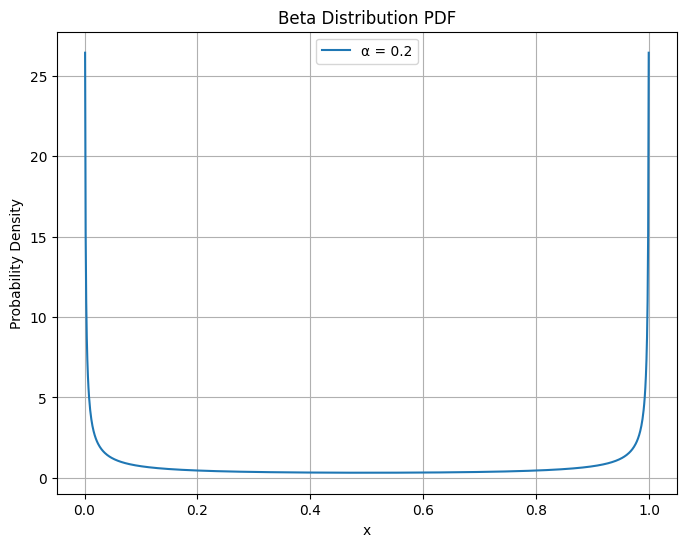

<Figure size 640x480 with 0 Axes>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# Set the hyperparameter α
alpha = 0.2

# Define the beta distribution
x = np.linspace(0, 1, 1000)
pdf = beta.pdf(x, alpha, alpha)

# Plot the PDF
plt.figure(figsize=(8, 6))
plt.plot(x, pdf, label=f'α = {alpha}')
plt.title('Beta Distribution PDF')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
lr = 0.05

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4865, 0.4409], std=[0.2673, 0.2564, 0.2762])
    ])

# Split data set
dataset = torchvision.datasets.CIFAR100(root='./data', train=True, transform=transform, download=True)
num_train = len(dataset)
indices = list(range(num_train))
split = int(np.floor(0.8 * num_train))  # 80% for training, 20% for validation
np.random.seed(0)
np.random.shuffle(indices)

train_indices, val_indices = indices[:split], indices[split:]

train_sampler = data.sampler.SubsetRandomSampler(train_indices)
val_sampler = data.sampler.SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=128, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=128, sampler=val_sampler)

# model
model = MobileNet(100)
#print(model)
model.cuda()

# criterion
criterion = torch.nn.CrossEntropyLoss().cuda()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

# scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=300, eta_min=0)

stat_training_loss = []
stat_val_loss = []
stat_training_acc = []
stat_val_acc = []

Files already downloaded and verified


In [17]:
alpha = 0.2
num_classes = 100
for epoch in range(300):
    training_loss = 0
    training_acc = 0
    training_samples = 0
    val_loss = 0
    val_acc = 0
    val_samples = 0
    # training
    model.train()
    for imgs, labels in train_loader:
        imgs = imgs.cuda()
        labels = labels.cuda()

        # Generate mixup factors and permute batch
        lam = np.random.beta(alpha, alpha)
        index = torch.randperm(imgs.size(0)).cuda()

        # Convert labels to one-hot encodings
        mixed_labels_one_hot = lam * F.one_hot(labels, num_classes=num_classes) + (1 - lam) * F.one_hot(labels[index], num_classes=num_classes)

        # Convert one-hot encodings back to class indices
        mixed_labels_indices = torch.argmax(mixed_labels_one_hot, dim=1)

        batch_size = imgs.shape[0]
        optimizer.zero_grad()
        logits = model.forward(imgs)
        loss = criterion(logits, mixed_labels_indices)
        loss.backward()
        optimizer.step()

        _, top_class = logits.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape).long()
        training_acc += torch.sum(equals.type(torch.FloatTensor)).item()
        training_loss += batch_size * loss.item()
        training_samples += batch_size

    # validation
    model.eval()
    for val_imgs, val_labels in valid_loader:
        batch_size = val_imgs.shape[0]
        val_logits = model.forward(val_imgs.cuda())
        loss = criterion(val_logits, val_labels.cuda())
        _, top_class = val_logits.topk(1, dim=1)
        equals = top_class == val_labels.cuda().view(*top_class.shape)
        val_acc += torch.sum(equals.type(torch.FloatTensor)).item()
        val_loss += batch_size * loss.item()
        val_samples += batch_size
    assert val_samples == 10000
    # update stats
    stat_training_loss.append(training_loss/training_samples)
    stat_val_loss.append(val_loss/val_samples)
    stat_training_acc.append(training_acc/training_samples)
    stat_val_acc.append(val_acc/val_samples)
    # print
    #print(f"Epoch {(epoch+1):d}/{args.epochs:d}.. Learning rate: {scheduler.get_lr()[0]:.4f}.. Train loss: {(training_loss/training_samples):.4f}.. Train acc: {(training_acc/training_samples):.4f}.. Val loss: {(val_loss/val_samples):.4f}.. Val acc: {(val_acc/val_samples):.4f}")

    print(f"Epoch {epoch + 1}/{300}.. "
          f"Learning rate: {scheduler.get_lr()[0]:.4f}.. "
          f"Train Loss: {training_loss / training_samples:.4f}.. "
          f"Train Acc: {training_acc / training_samples:.4f}.. "
          f"Validation Loss: {val_loss / val_samples:.4f}.. "
          f"Validation Acc: {val_acc / val_samples:.4f}")
    # lr scheduler
    scheduler.step()

Epoch 1/300.. Learning rate: 0.0500.. Train Loss: 4.5951.. Train Acc: 0.0328.. Validation Loss: 4.3972.. Validation Acc: 0.0571
Epoch 2/300.. Learning rate: 0.0500.. Train Loss: 4.4889.. Train Acc: 0.0619.. Validation Loss: 4.1484.. Validation Acc: 0.0767
Epoch 3/300.. Learning rate: 0.0500.. Train Loss: 4.4388.. Train Acc: 0.0873.. Validation Loss: 4.0449.. Validation Acc: 0.0912
Epoch 4/300.. Learning rate: 0.0500.. Train Loss: 4.3552.. Train Acc: 0.1040.. Validation Loss: 3.9870.. Validation Acc: 0.1071
Epoch 5/300.. Learning rate: 0.0500.. Train Loss: 4.3814.. Train Acc: 0.1270.. Validation Loss: 3.9240.. Validation Acc: 0.1169
Epoch 6/300.. Learning rate: 0.0500.. Train Loss: 4.3675.. Train Acc: 0.1379.. Validation Loss: 3.9439.. Validation Acc: 0.1436
Epoch 7/300.. Learning rate: 0.0499.. Train Loss: 4.3390.. Train Acc: 0.1508.. Validation Loss: 3.7883.. Validation Acc: 0.1533
Epoch 8/300.. Learning rate: 0.0499.. Train Loss: 4.2550.. Train Acc: 0.1679.. Validation Loss: 3.6796..

In [18]:
plot_loss_acc(stat_training_loss, stat_val_loss, stat_training_acc, stat_val_acc, "mixup_2")

## Test Set

In [19]:
# Load the test dataset

test_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4865, 0.4409], std=[0.2673, 0.2564, 0.2762])
    ])

test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, transform=test_transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

# Evaluate the model on the test set
model.eval()
test_acc = 0
test_samples = 0

for test_imgs, test_labels in test_loader:
    batch_size = test_imgs.shape[0]
    with torch.no_grad():
        test_logits = model(test_imgs.cuda())
    _, top_class = test_logits.topk(1, dim=1)
    equals = top_class == test_labels.cuda().view(*top_class.shape)
    test_acc += torch.sum(equals.type(torch.FloatTensor)).item()
    test_samples += batch_size

assert test_samples == len(test_loader.dataset)

# Calculate and print the test accuracy
test_accuracy = test_acc / test_samples
print(f'Test Accuracy: {test_accuracy:.4f}')


Files already downloaded and verified
Test Accuracy: 0.6511
